# How to use Mujoco for 3D LLM

In [ ]:
import mujoco
import mediapy as media  # For renderer
import numpy as np

""

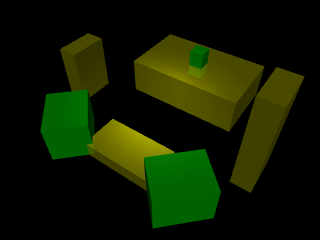

Contact points between Coffee_Table and Plush_Armchair 
	at [-136.36038969  264.14213562   20.        ], 
	distance: -13.639610306789276
Contact points between Coffee_Table and Plush_Armchair 
	at [-136.36038969  264.14213562  -40.        ], 
	distance: -13.639610306789276
Contact points between Coffee_Table and Elegant_Armchair 
	at [136.36038969 264.14213562  20.        ], 
	distance: -13.639610306789276
Contact points between Coffee_Table and Elegant_Armchair 
	at [136.36038969 264.14213562 -40.        ], 
	distance: -13.639610306789276
Contact points between Dining_Table and Table_Lamp 
	at [ -30. -330.   85.], 
	distance: -25.0
Contact points between Dining_Table and Table_Lamp 
	at [  30. -330.   85.], 
	distance: -25.0
Contact points between Dining_Table and Table_Lamp 
	at [ -30. -270.   85.], 
	distance: -25.0
Contact points between Dining_Table and Table_Lamp 
	at [  30. -270.   85.], 
	distance: -25.0


In [ ]:
# Example of a living room
model = mujoco.MjModel.from_xml_path("living_room.xml")
data = mujoco.MjData(model)
mujoco.mj_kinematics(model, data)

# Set up a camera to render the scene. Make renderer, render and show the pixel.
camera = mujoco.MjvCamera()
camera.lookat[:] = [0, 0, 0]  # Set the point the camera looks at
camera.distance = 1200.0  # Set the distance from the object
camera.azimuth = -55  # Set the azimuth angle (horizontal rotation)
camera.elevation = -45  # Set the elevation angle (vertical rotation)
with mujoco.Renderer(model) as renderer:
    mujoco.mj_forward(model, data)
    renderer.update_scene(data, camera=camera)
    media.show_image(renderer.render())

# Print all contacts between objects (due to collision)
mujoco.mj_step(model, data)
for i in range(data.ncon):  # data.ncon is the number of active contacts
    contact = data.contact[i]
    geom1 = mujoco.mj_id2name(model, mujoco.mjtObj.mjOBJ_GEOM, contact.geom1)
    geom2 = mujoco.mj_id2name(model, mujoco.mjtObj.mjOBJ_GEOM, contact.geom2)
    pos = contact.pos  # Contact position (x, y, z)
    dist = contact.dist  # Penetration distance
    print(
        f"Contact points between {geom1} and {geom2} \n\tat {pos}, \n\tdistance: {dist}"
    )

    # Get contact force (debug only)
    # force = np.zeros(6)  # Placeholder for force and torque
    # mujoco.mj_contactForce(model, data, i, force)
    # linear_force = force[:3]  # Linear force (x, y, z)
    # torque = force[3:]  # Torque (rotational force)
    # print(f"Contact force: \n\tlinear = {linear_force}, torque = {torque}\n")

In [190]:
# Set num steps to iterate mj_step
num_steps = 30

# Reset state and time, save objects' initial positions
mujoco.mj_resetData(model, data)
mujoco.mj_kinematics(model, data)
init_pos = np.copy(data.geom_xpos)

# Simulate and display video.
frames = []
with mujoco.Renderer(model) as renderer:
    for step in range(num_steps):
        data.qvel = np.zeros(data.qvel.size)
        mujoco.mj_step(model, data)
        renderer.update_scene(data, camera=camera)
        pixels = renderer.render()
        frames.append(pixels)
media.show_video(frames)

# Print befoer and after object positions
final_pos = np.copy(data.geom_xpos)
print("Virtual objects were corrected to non-colliding positions:")
for i in range(model.ngeom):
    if (init_pos[i] != final_pos[i]).any():
        geom_name = mujoco.mj_id2name(model, mujoco.mjtObj.mjOBJ_GEOM, i)
        print(f"{geom_name}: {init_pos[i]} -> {final_pos[i]}")

Virtual objects were corrected to non-colliding positions:
Plush_Armchair: [-250.  250.   40.] -> [-276.33420315  247.54316814   43.62917179]
Elegant_Armchair: [250. 250.  40.] -> [276.33420315 247.54316814  43.62917179]
Table_Lamp: [   0. -300.  120.] -> [-4.69378737e-16 -3.00000000e+02  1.68991675e+02]
